# DPT-DINOv2

In [16]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import rawpy
from IPython.display import display, HTML
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cv2
from sklearn.preprocessing import normalize
import os
from skimage.transform import resize
import random

def display_image_small(im, width=500):
    w, h = im.size
    height = int(h * (width / w))
    image = im.resize((width, height))
    display(image)

def open_image(path, depth_path, result_ground_truth_image_path,img_dim, save_ground_truth=False, display=False):
    depth_img = tiff.imread(depth_path)
    depth_img = resize(depth_img, (img_dim[1], img_dim[0]), order=1, mode='constant', anti_aliasing=False)
    formatted = (depth_img * 255 / np.max(depth_img)).astype("uint8")
    colored_depth = cv2.applyColorMap(formatted, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    depth = Image.fromarray(colored_depth)
    if save_ground_truth:
        # save the ground truth image
        depth.save(result_ground_truth_image_path, format='png')
    # Display the shape of the image array
    with rawpy.imread(path) as raw_image:
        rgb = raw_image.postprocess()
        image = Image.fromarray(rgb)
        # print(f"Original image size: {w}x{h}")
        # print(f"Resized image size: {width}x{height}")
        image = image.resize(img_dim)
        if display:
            print("raw image and ground truth")
            display_image_small(image)
            
            display_image_small(depth)
    return image, depth_img

def preprocess_image(image_processor, image):
    # prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")
    return inputs

def predict_depth(model, inputs):
    #forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    return predicted_depth

def post_process_depth(depth, image, predicted_depth_path, display=False):
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    colored_depth = cv2.applyColorMap(formatted, cv2.COLORMAP_INFERNO)[:, :, ::-1]
    depth = Image.fromarray(colored_depth)
    # depth.save(predicted_depth_path, format='png')
    if display:
        display_image_small(depth)
    return output, colored_depth, depth

def plot_one_over_z_vs_d(actual_depth, model_output, save_folder, img_name):
    # Remove zero values
    z = actual_depth.flatten()
    d = model_output.flatten()

    non_zero = np.where(z > 0.33)
    z = 1/z[non_zero]
    d = d[non_zero]
    # Scatter plot
    plt.scatter(z, d, s=1)
    plt.xlabel("1/z")
    plt.ylabel("d")

    # Linear regression
    result = linregress(z, d)

    # Line of best fit
    fit_x = np.linspace(np.min(z), np.max(z), 100)
    fit_y = result.slope * fit_x + result.intercept
    plt.plot(fit_x, fit_y, '-r', label='Line of best fit, r = {:.3f}'.format(result.rvalue))
    # Display R-squared value
    plt.legend()
    plt.title(f"1/z vs d for {img_name}")
    # Save the plot as an image file using PIL
    # fig = plt.gcf()
    # plt.set_size_inches(6, 4)
    # plt.savefig(save_folder, dpi=100, bbox_inches='tight')
    # plt.close()
    return result.rvalue

def underwater_depth_model_analysis(model_path, image_name, dataset_name, raw_image_path, actual_depth_path, results_path, img_dim=(664,443), save_ground_truth=False, display=False):
    # initialise model
    plot_path = f'{results_path}/plot/{image_name}.PNG'
    result_ground_truth_image_path = f'Datasets/{dataset_name}/depth_png/{image_name}.png'
    predicted_depth_path = f'{results_path}/predicted_depth/{image_name}.png'
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModelForDepthEstimation.from_pretrained(model_path)
    raw_image, actual_depth = open_image(path=raw_image_path, depth_path=actual_depth_path, 
                                         result_ground_truth_image_path=result_ground_truth_image_path, 
                                         img_dim=img_dim, save_ground_truth=save_ground_truth, display=display)
    inputs = preprocess_image(image_processor=image_processor, image=raw_image)
    predicted_depth = predict_depth(model=model, inputs=inputs)
    model_output, formatted, depth_im = post_process_depth(depth=predicted_depth, image=raw_image, predicted_depth_path=predicted_depth_path, display=display)
    rvalue = plot_one_over_z_vs_d(actual_depth, model_output, plot_path, image_name)
    return rvalue



img_name = "T_S03047"
raw = f"D1/Raw/{img_name}.ARW"
actual_depth_path = f"D1/depth/depth{img_name}.tif"


In [17]:
random_images = {'D1': ['T_S03376.ARW',
  'T_S03386.ARW',
  'T_S03305.ARW',
  'T_S03515.ARW',
  'T_S03175.ARW',
  'T_S03116.ARW',
  'T_S03338.ARW',
  'T_S03265.ARW',
  'T_S03330.ARW',
  'T_S03291.ARW'],
 'D3': ['T_S04900.ARW',
  'T_S04857.ARW',
  'T_S04871.ARW',
  'T_S04870.ARW',
  'T_S04923.ARW',
  'T_S04874.ARW',
  'T_S04866.ARW',
  'T_S04904.ARW',
  'T_S04876.ARW',
  'T_S04890.ARW'],
 'D5': ['LFT_3384.NEF',
  'LFT_3381.NEF',
  'LFT_3396.NEF',
  'LFT_3392.NEF',
  'LFT_3375.NEF',
  'LFT_3414.NEF',
  'LFT_3388.NEF',
  'LFT_3385.NEF',
  'LFT_3380.NEF',
  'LFT_3412.NEF']}

Processed 5 images
Processed 10 images
Processed 15 images
Processed 20 images
Processed 25 images
Processed 30 images
Processed 35 images
Processed 40 images


d:\mukul\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
d:\mukul\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


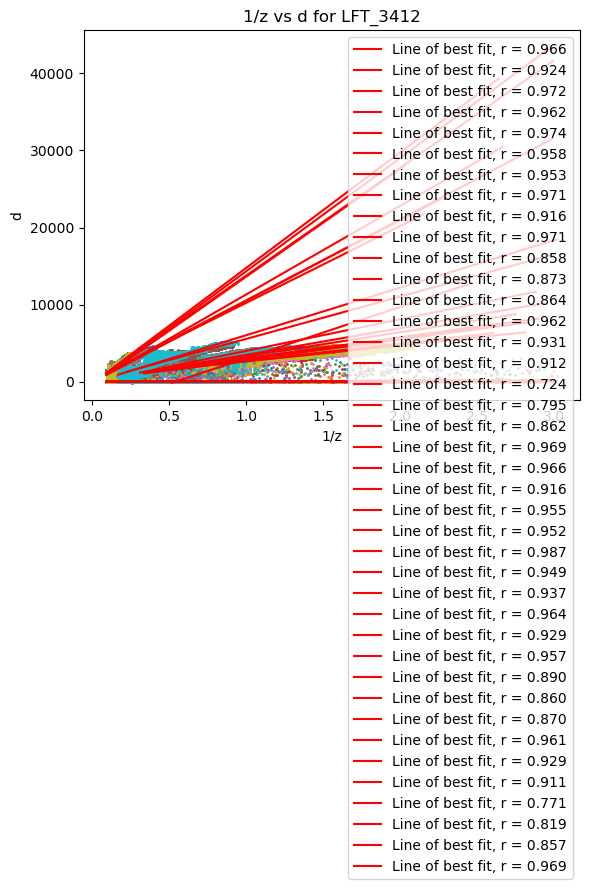

In [18]:
raw_image_count = 0
datasets_dir = 'Datasets'
results_dir = 'Results'
default_image_dim = (576,384)
models = {"model_dpt3_1": "Intel/dpt-swinv2-large-384", "model_depth_anything": "nielsr/depth-anything-small"}
# models = {"model_depth_anything": "nielsr/depth-anything-small"}
mean_r_values = {}
save_ground_truth = True
nsample_images = 10
# selected_raw_images = {}
selected_raw_images = random_images
for model_name, model_path in models.items():
    results_paths = {}
    for dataset_dir in os.listdir(datasets_dir):
        dataset_path = datasets_dir + '/' + dataset_dir
        dataset_name = os.path.basename(dataset_path)
        if dataset_name == 'D1':
            continue
        results_paths[dataset_name]= results_dir + '/'+ model_name + '/' + dataset_name
        if not os.path.exists(results_paths[dataset_name]):
            os.makedirs(results_paths[dataset_name]+ '/plot')
            os.makedirs(results_paths[dataset_name]+ '/predicted_depth')
        raw_images = dataset_path + '/Raw'
        depth_images = dataset_path + '/depth'
        if os.path.isdir(raw_images):
            mean_r_values[(model_name, dataset_name)] = 0
            if dataset_name not in selected_raw_images.keys():  
                all_raw_images = os.listdir(raw_images)
                selected_raw_images[dataset_name] = random.sample(all_raw_images, nsample_images)
            for raw_image in selected_raw_images[dataset_name]:
                raw_image_path = raw_images + '/' + raw_image
                raw_image_name = raw_image[:-4]
                depth_image_path = depth_images + '/depth' + raw_image_name + '.tif'

                r_value = underwater_depth_model_analysis(model_path=model_path, image_name=raw_image_name, 
                                                          dataset_name=dataset_name, raw_image_path=raw_image_path, 
                                                          actual_depth_path=depth_image_path, results_path=results_paths[dataset_name], 
                                                          img_dim=default_image_dim, save_ground_truth=save_ground_truth, display=False)
                mean_r_values[(model_name, dataset_name)] += r_value
                # print(depth_image_path)
                # underwater_depth_model_analysis(dataset_name, model_dinov2, raw_image_path, depth_image_path)
                raw_image_count += 1
                if raw_image_count % 5 == 0:
                    print(f"Processed {raw_image_count} images")
            mean_r_values[(model_name, dataset_name)] /= nsample_images
                
    save_ground_truth = False
    


In [19]:
print(mean_r_values)

{('model_dpt3_1', 'D3'): 0.9565786855518932, ('model_dpt3_1', 'D5'): 0.8749631461350644, ('model_depth_anything', 'D3'): 0.9511714458064612, ('model_depth_anything', 'D5'): 0.8836194136502927}
